In [52]:
import pandas as pd
import geopandas
import numpy as np
from math import pi
from matplotlib import pyplot as plt
import seaborn as sns
import common.common_pandas_lib as common

## Configuraciones

In [53]:
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib


#pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

### Configuraciones plot

In [54]:
TAM_TITULO = 35
TAM_ETIQUETA = 30

### Configuraciones de librerias

### Funciones auxiliares

In [55]:
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

sns.set(style="whitegrid", font_scale = 2) # seteando tipo de grid en seaborn
                                           # seteando tamanio de ticks label
pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

TAM_TITULO = 36

def crear_radar_superpuestos(categorias, datos_a, datos_b, leyenda_a, leyenda_b, titulo):
    #Basado en https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
    N = len(categorias)
    angulos = [n / float(N) * 2 * pi for n in range(N)]
    angulos += angulos[:1]
    print(angulos)

    ax = plt.subplot(111, polar=True)
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angulos[:-1], categorias, color='grey')
    
    ax.set_rlabel_position(0)
    plt.yticks([1, 2, 3, 4], ["1", "2", "3", "4"], color="grey", size=15)
    plt.ylim(0,5)
    
    values = list(datos_a)
    values += values[:1]
    ax.plot(angulos, values, linewidth=2, linestyle='solid', markerfacecolor='blue', label=leyenda_a)
    ax.fill(angulos, values, 'b', alpha=0.1)

    values = list(datos_b)
    values += values[:1]
    ax.plot(angulos, values, linewidth=2, linestyle='solid', markerfacecolor='yellow',label=leyenda_b)
    ax.fill(angulos, values, 'y', alpha=0.1)
    
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.title(titulo, size=TAM_TITULO, y=1.1)

In [56]:
df = pd.read_csv('train.csv', \
       dtype = { \
                'id' : np.int32, \

                'ciudad' : 'category', \
                'antiguedad' : np.float16, \
                'habitaciones' : np.float16, \
                'garages' : np.float16, \
                'banos' : np.float16, \
                'metroscubiertos' : np.float16, \
                'metrostotales' : np.float16, \
                'idzona' : np.float32, \
                'gimnasio' : 'bool', \
                'usosmultiples' : 'bool', \
                'piscina' : 'bool', \
                'escuelascercanas' : 'bool', \
                'centroscomercialescercanos' : 'bool', \
                'precio' : np.float32 \
               },
        parse_dates = ['fecha'],
        date_parser = pd.to_datetime                                
    )



## Cantidad de NAN en campos a analizar

### Cantidad de NAN en provincia:

In [57]:
n_provincia_nan = df["provincia"].isnull().sum()
n_provincia_nan

155

### Cantidad de NAN en precio:

In [58]:
n_tipodepropiedad_nan = df["tipodepropiedad"].isnull().sum()
n_tipodepropiedad_nan

46

## ¿Cuáles son las provincias con propiedades más caras y cuáles con las más baratas?

In [59]:
provincia_precio = df.groupby('provincia')['precio'].mean()

(<Figure size 1000x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2bd3a2fc0f0>)

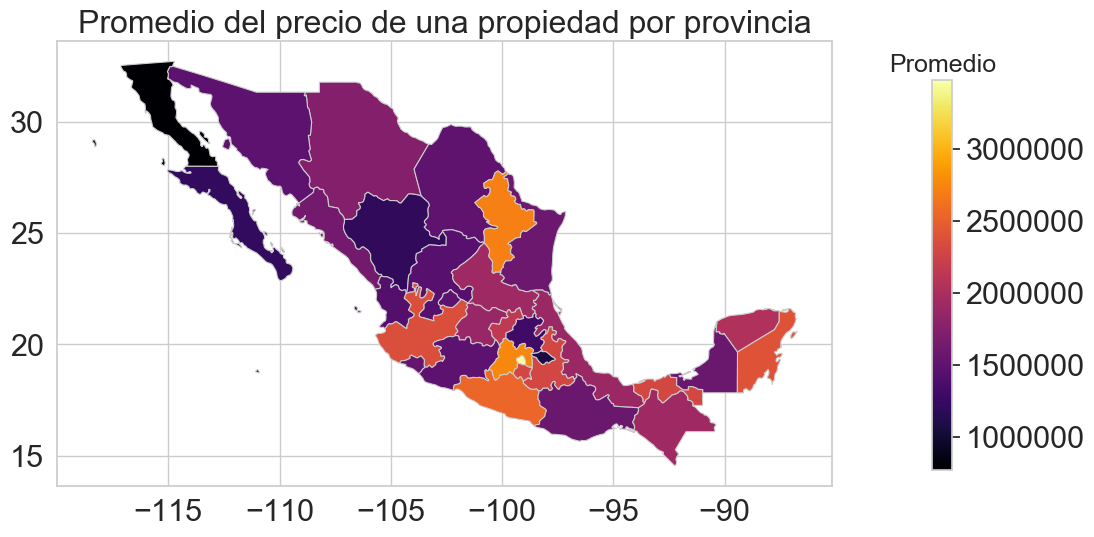

<Figure size 1250x1250 with 0 Axes>

In [60]:
common.crear_mapa(provincia_precio, "precio", provincia_precio.min(), provincia_precio.max(), "Promedio del precio de una propiedad por provincia", "Promedio", "inferno")

### Top 5 provincias con viviendas más caras

In [61]:
#provincia_precio_df = provincia_precio.to_frame()
#provincia_precio_df.rename(columns = {'precio': 'Precio promedio de propiedad'}, inplace=True)
provincias_caras_df = provincia_precio.nlargest(5).to_frame()
provincias_caras_df.rename(columns = {'precio': 'Mayores promedios en precio de propiedad'}, inplace=True)
provincias_caras_df

,Mayores promedios en precio de propiedad
provincia,
Distrito Federal,"3,471,705.00"
Edo. de México,"2,762,465.00"
Nuevo León,"2,717,757.75"
Guerrero,"2,548,741.75"
Quintana Roo,"2,402,967.00"


In [62]:
#provincias_caras = provincia_precio_df.nlargest(6, "Precio promedio de propiedad")
#provincias_caras.rename(columns = {'precio': 'Mayores promedios en precios de propiedades'}, inplace=True)
#provincias_caras
provincias_baratas_df = provincia_precio.nsmallest(5).to_frame()
provincias_baratas_df.rename(columns = {'precio': 'Menores promedios en precio de propiedad'}, inplace=True)
provincias_baratas_df

,Menores promedios en precio de propiedad
provincia,
Baja California Norte,"767,441.75"
Tlaxcala,"1,080,993.38"
Durango,"1,210,389.00"
Baja California Sur,"1,216,452.88"
Hidalgo,"1,305,550.50"


### Top 5 estados con viviendas más baratas

In [63]:
provincias_baratas = provincia_precio_df.nsmallest(6, "Precio promedio de propiedad")
provincias_baratas

,Precio promedio de propiedad
provincia,
Baja California Norte,"767,441.75"
Tlaxcala,"1,080,993.38"
Durango,"1,210,389.00"
Baja California Sur,"1,216,452.88"
Hidalgo,"1,305,550.50"
Nayarit,"1,426,790.88"


## Promedios de las características de las propiedades por provincia

In [64]:
categorias = ["precio", "habitaciones", "banos", "garages"]

### Promedios de las caracteristicas de las provincias con propiedades más caras:

In [65]:
provincias_caras_df = df[df["provincia"].isin(list(provincias_caras.index))]
provincias_caras_df = provincias_caras_df.groupby("provincia")[categorias].mean()
provincias_caras_df = provincias_caras_df.sort_values("precio", ascending  = False)
provincias_caras_df = provincias_caras_df.drop(["precio"], axis=1)
provincias_caras_df
#df, edo, leon, guerrero, quinbtana, jalisco

,habitaciones,banos,garages
provincia,,,
Distrito Federal,2.74,1.99,1.42
Edo. de México,2.97,2.08,1.66
Nuevo León,2.94,2.31,1.53
Guerrero,2.82,2.29,1.33
Quintana Roo,2.85,2.34,1.58
Jalisco,3.03,2.22,1.53


<Figure size 640x480 with 0 Axes>

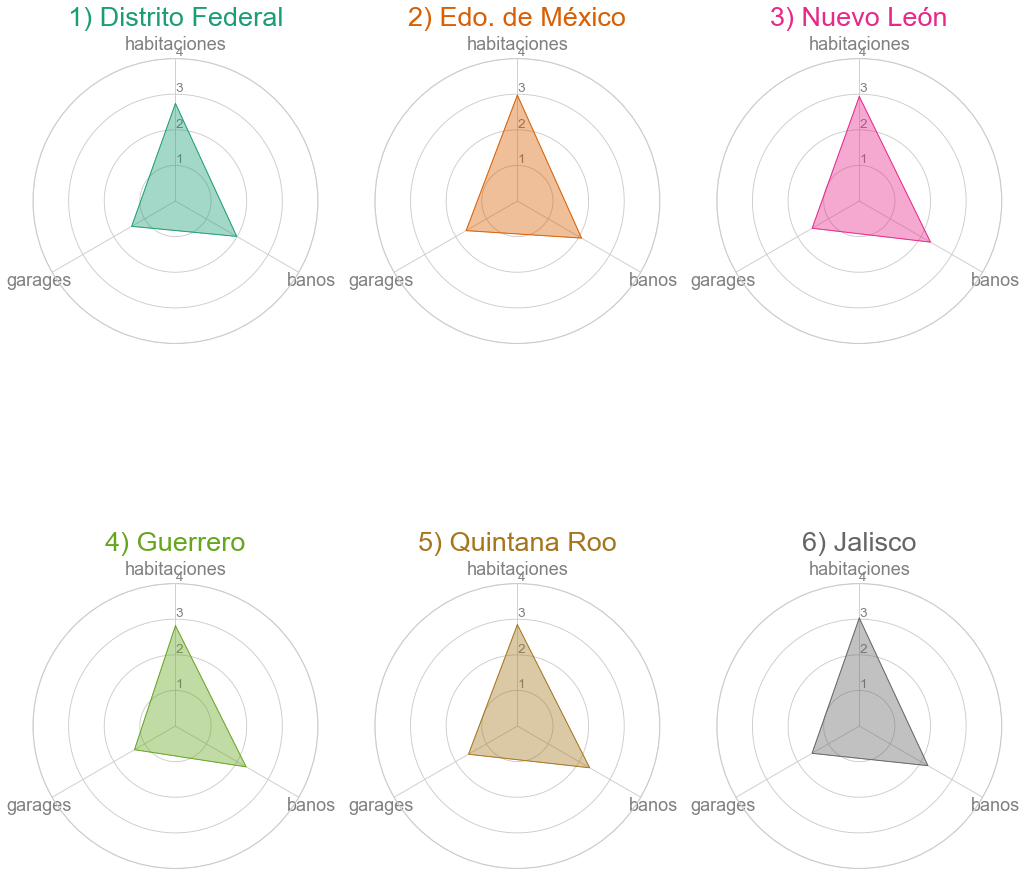

<Figure size 640x480 with 0 Axes>

In [66]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)
 
common.crear_radares_alineados(provincias_caras_df.reset_index(), 2, 3, "Dark2")

### Promedios de las caracteristicas de las provincias con propiedades más baratas:

In [67]:
provincias_baratas_df = df[df["provincia"].isin(list(provincias_baratas.index))]
provincias_baratas_df = provincias_baratas_df.groupby("provincia")[categorias].mean()
provincias_baratas_df = provincias_baratas_df.sort_values("precio")
provincias_baratas_df = provincias_baratas_df.drop(["precio"], axis=1)
provincias_baratas_df

,habitaciones,banos,garages
provincia,,,
Baja California Norte,2.58,1.37,1.61
Tlaxcala,2.83,1.55,1.38
Durango,3.05,1.95,1.47
Baja California Sur,2.63,1.61,1.68
Hidalgo,2.88,1.81,1.48
Nayarit,2.75,1.89,0.89


<Figure size 640x480 with 0 Axes>

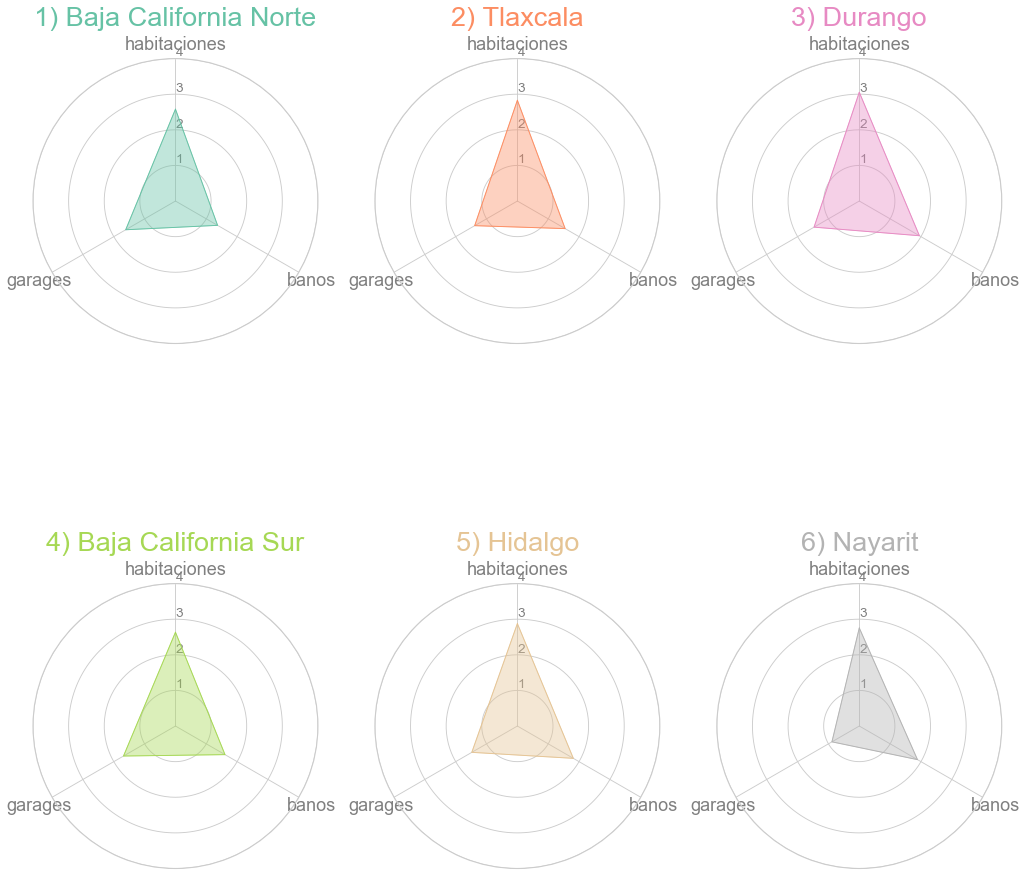

<Figure size 640x480 with 0 Axes>

In [68]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)
 
common.crear_radares_alineados(provincias_baratas_df.reset_index(), 2, 3, "Set2")

### Promedios de las caracteristicas de las provincias con más propiedades:

In [69]:
provincias_pobladas = df["provincia"].value_counts().nlargest(6)
provincias_pobladas_df = df[df["provincia"].isin(list(provincias_pobladas.index))]
provincias_pobladas_df = provincias_pobladas_df.groupby("provincia")["habitaciones", "banos", "garages"].mean()
provincias_pobladas = provincias_pobladas.to_frame()
provincias_pobladas_df = provincias_pobladas_df.merge(provincias_pobladas, how = "inner", left_index=True, right_index=True)
provincias_pobladas_df =  provincias_pobladas_df.sort_values("provincia", ascending = False)
provincias_pobladas_df = provincias_pobladas_df.drop(["provincia"], axis=1)
provincias_pobladas_df.index.name = "provincia"
provincias_pobladas_df
#df, edo, jalis, que, nueva, puebla

,habitaciones,banos,garages
provincia,,,
Distrito Federal,2.74,1.99,1.42
Edo. de México,2.97,2.08,1.66
Jalisco,3.03,2.22,1.53
Querétaro,2.98,2.40,1.75
Nuevo León,2.94,2.31,1.53
Puebla,2.92,2.25,1.66


<Figure size 640x480 with 0 Axes>

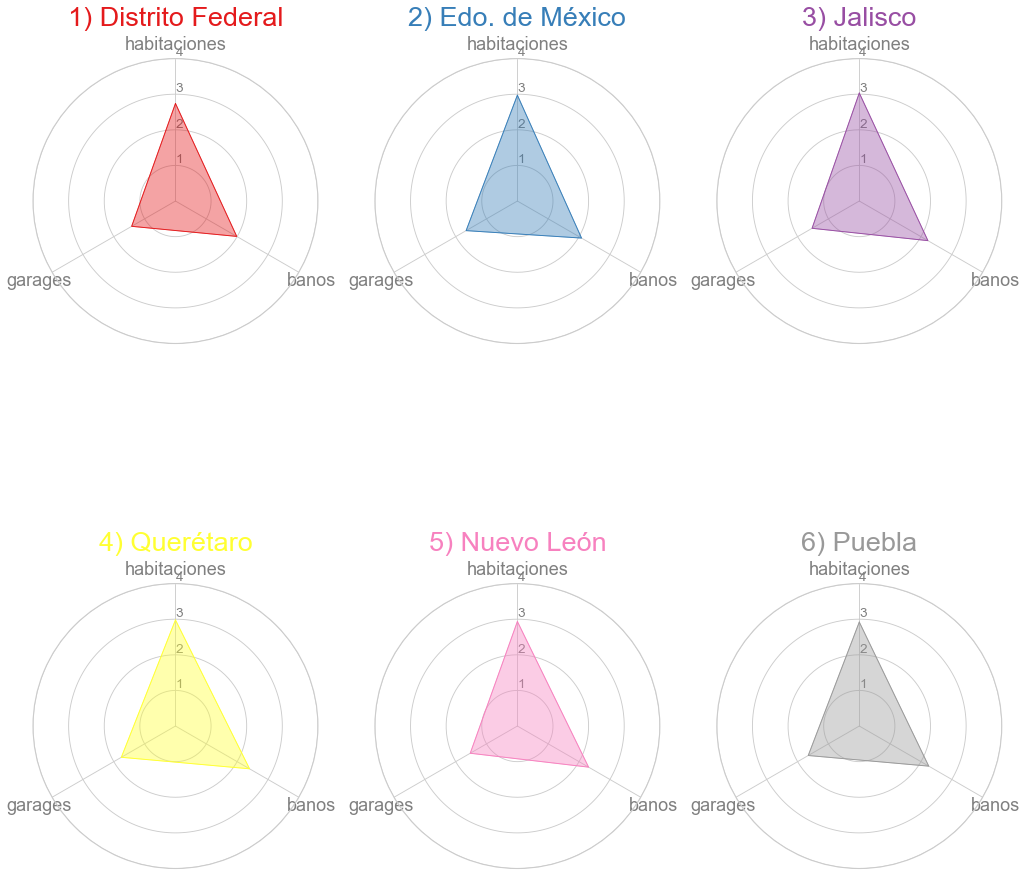

<Figure size 640x480 with 0 Axes>

In [70]:
my_dpi=65
plt.figure(figsize=(1250/my_dpi, 1250/my_dpi), dpi=my_dpi)

common.crear_radares_alineados(provincias_pobladas_df.reset_index(), 2, 3, "Set1")

### Comparación de las 6 provincias con propiedades más caras y 6 provincias con propiedades más baratas

In [71]:
provincias_caras_df

,habitaciones,banos,garages
provincia,,,
Distrito Federal,2.74,1.99,1.42
Edo. de México,2.97,2.08,1.66
Nuevo León,2.94,2.31,1.53
Guerrero,2.82,2.29,1.33
Quintana Roo,2.85,2.34,1.58
Jalisco,3.03,2.22,1.53


In [72]:
promedios_provincias_caras = provincias_caras_df[["habitaciones", "banos", "garages"]].mean()
promedios_provincias_caras

habitaciones                   2.89
banos                          2.21
garages                        1.51
dtype: float16

In [73]:
promedios_provincias_baratas = provincias_baratas_df[["habitaciones", "banos", "garages"]].mean()
promedios_provincias_baratas

habitaciones                   2.79
banos                          1.70
garages                        1.42
dtype: float16

[0.0, 2.0943951023931953, 4.1887902047863905, 0.0]


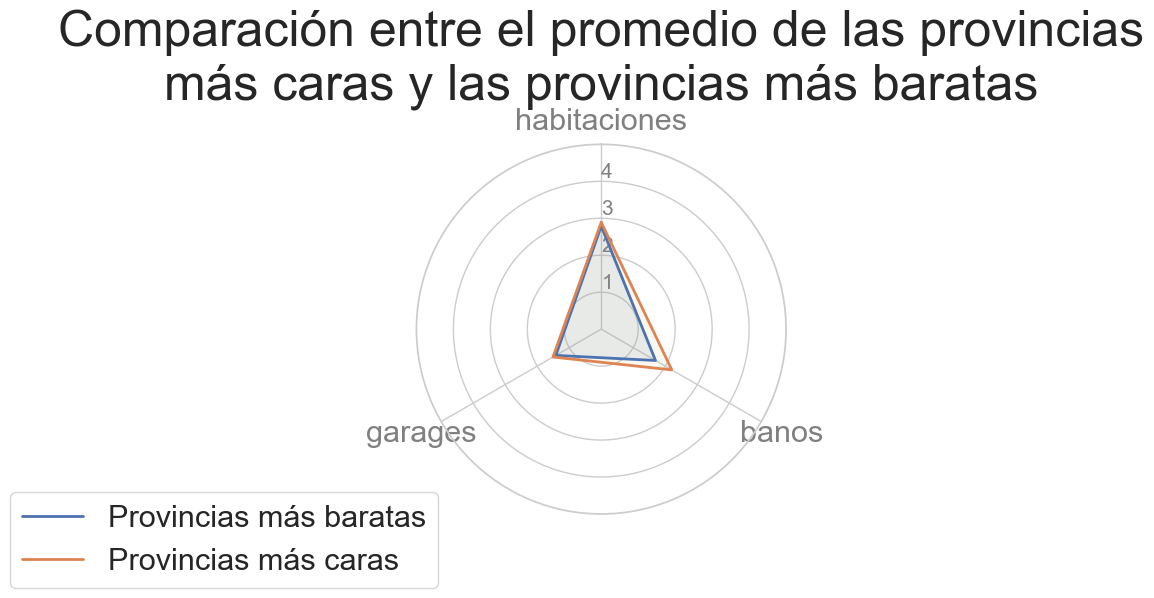

In [74]:
categorias = ["habitaciones", "banos", "garages"]
crear_radar_superpuestos(categorias, promedios_provincias_baratas, promedios_provincias_caras,
                         "Provincias más baratas", "Provincias más caras",
                         "Comparación entre el promedio de las provincias\nmás caras y las provincias más baratas")